In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.stats as stats
from statsmodels.tsa.stattools import acf

In [3]:
dir = "figures"
os.makedirs(dir, exist_ok=True)

In [4]:
### Data loading

def load_data(filepath):

    try:
        df = pd.read_csv(filepath)
        # Check for standard Oxford Man columns
        if 'Symbol' in df.columns and 'rv5' in df.columns:
            # Clean up dates
            df['Date'] = pd.to_datetime(df['Unnamed: 0'] if 'Unnamed: 0' in df.columns else df.index, utc=True)
            df.set_index('Date', inplace=True)
            return df
        else:
            print("Columns 'Symbol' and 'rv5' exist")
            return None
    except FileNotFoundError:
        print(f"File {filepath} not found")

DATA_FILE = 'data/oxfordmanrealizedvolatilityindices.csv' 
full_data = load_data(DATA_FILE)

In [5]:
full_data.head(6)

,Unnamed: 0,Symbol,rv5_ss,close_time,rsv_ss,open_time,rk_parzen,rv5,rv10_ss,bv,close_price,rv10,open_price,rk_twoscale,medrv,bv_ss,open_to_close,nobs,rsv,rk_th2
Date,,,,,,,,,,,,,,,,,,,,
2000-01-03 00:00:00+00:00,2000-01-03 00:00:00+00:00,.AEX,0.000130,163015.0,0.000046,90101.0,0.000179,0.000130,0.000178,0.000100,675.44,0.000178,675.67,0.000103,0.000050,0.000100,-0.000340,1795.0,0.000046,0.000102
2000-01-04 00:00:00+00:00,2000-01-04 00:00:00+00:00,.AEX,0.000201,163016.0,0.000147,90416.0,0.000423,0.000201,0.000261,0.000207,642.25,0.000261,664.20,0.000199,0.000075,0.000207,-0.033606,1785.0,0.000147,0.000201
2000-01-05 00:00:00+00:00,2000-01-05 00:00:00+00:00,.AEX,0.000491,163016.0,0.000328,90016.0,0.000324,0.000491,0.000714,0.000361,632.31,0.000714,633.37,0.000325,0.000166,0.000361,-0.001675,1801.0,0.000328,0.000345
2000-01-06 00:00:00+00:00,2000-01-06 00:00:00+00:00,.AEX,0.000225,163002.0,0.000116,90016.0,0.000219,0.000225,0.000182,0.000258,624.21,0.000182,632.46,0.000218,0.000152,0.000258,-0.013130,1799.0,0.000116,0.000221
2000-01-07 00:00:00+00:00,2000-01-07 00:00:00+00:00,.AEX,0.000138,163016.0,0.000048,90046.0,0.000155,0.000138,0.000157,0.000130,644.86,0.000157,628.93,0.000126,0.000039,0.000130,0.025013,1798.0,0.000048,0.000123
2000-01-10 00:00:00+00:00,2000-01-10 00:00:00+00:00,.AEX,0.000109,163017.0,0.000062,90146.0,0.000086,0.000109,0.000126,0.000089,655.14,0.000126,651.82,0.000074,0.000032,0.000089,0.005081,1794.0,0.000062,0.000073


In [7]:
# Filter for SPX and get Realized Variance (using rv5)
spx_data = full_data[full_data['Symbol'] == '.SPX'].copy()
# rv_col = 'rk_th2' 
rv_col = 'rv5'
spx_rk = spx_data[rv_col]

---
### ACF ESTIMATOR FOR $H$


The covariance structure of fBm is given by

$$
\mathbb{E}\left[ W^H_t W^H_s \right] = \frac{1}{2} \left( t^{2H} + s^{2H} - |t-s|^{2H} \right)

$$

let

$$
y_t = \log v_t = W^H_t.
$$

Then
$$
\text{Var}(y_t) = \langle y_t^2 \rangle - \langle y_t \rangle^2 = t^{2H}
$$
and
$$
\langle y_t y_{t+\Delta} \rangle = \frac{1}{2} \left[ t^{2H} + (t+\Delta)^{2H} - \Delta^{2H} \right]
$$


Dividing one by the other gives

$$
\rho(\Delta) = \frac{\langle y_t y_{t+\Delta} \rangle}{\text{Var}(y_t)} =  \frac{1}{2}\,\left\{1 + \left(1+\frac\Delta t\right)^{2 H} - \left(\frac\Delta t\right)^{2 H}\right\}
$$


Thus, for $\Delta/t$ sufficiently small,


$$
1-\rho(\Delta) =\frac12 \left(\frac{\Delta}{t}\right)^{2 H} + O\left(\frac{\Delta}t\right).
$$

- Note in particular that we expect the ACF estimator to work best when $H \ll \frac{1}{2}$.  

- Also, when $H=\frac12$, we have 
$
\rho(\Delta) = 1
$
as we would expect for Brownian motion.

### The ACF estimator

Taking logs of each side, we obtain

$$
\log(1- \rho(\Delta)) = a + 2\,H\, \log \Delta.
$$

- Thus $H$ can be estimated efficiently by regression.


In [8]:
def estimate_h_acf(series, lags=50):
    """
    Estimates H using the ACF method: log(1 - rho(Delta)) ~ a + 2H log(Delta)
    """
    # Calculate ACF using stat-model
    rho = acf(series, nlags=lags, fft=True)
    
    y_reg = np.log(1 - rho[1:])
    x_reg = np.log(np.arange(1, len(rho))) # lags from 1 to lags=
    
    # line fit
    slope, intercept, _, _, _ = stats.linregress(x_reg, y_reg)
    
    # H from slope
    H_est = slope / 2
    return H_est

# log_rv = np.log(spx_rk)
log_rv = np.log(np.sqrt(spx_rk)) ## log (volatility)
h_acf_val = estimate_h_acf(log_rv, lags=50)
print(f"H estimated via ACF (whole time series): {h_acf_val:.4f}")

H estimated via ACF (whole time series): 0.1479


---
###  $H$ for certain portion of the TIME SERIES

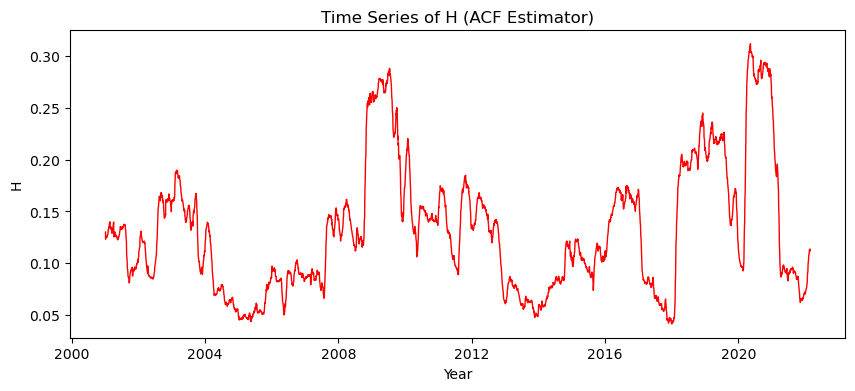

In [9]:
# At each date t, the code takes the previous window_size=252(1yr) observations, 
# computes their ACF up to lags_for_ac= 40, and from the scaling of those correlations estimates 
# a single Hurst exponent H

def rolling_h_acf(series, window_size=252, lags_for_acf=20):

    results = []
    indices = []
    
    arr = series.values
    for i in range(window_size, len(arr)):
        window = arr[i-window_size : i]
        # Estimate H on this window
        try:
            h = estimate_h_acf(window, lags=lags_for_acf)
            results.append(h)
            indices.append(series.index[i])
        except:
            results.append(np.nan)
            indices.append(series.index[i])
            
    return pd.Series(results, index=indices)

rolling_H = rolling_h_acf(log_rv, window_size=252, lags_for_acf=60) # 1 year window

plt.figure(figsize=(10,4))
plt.plot(rolling_H, color='red', linewidth=1)
plt.title('Time Series of H (ACF Estimator)')
plt.ylabel('H')
plt.xlabel('Year')
plt.show()


### Plot H and volatility side by side

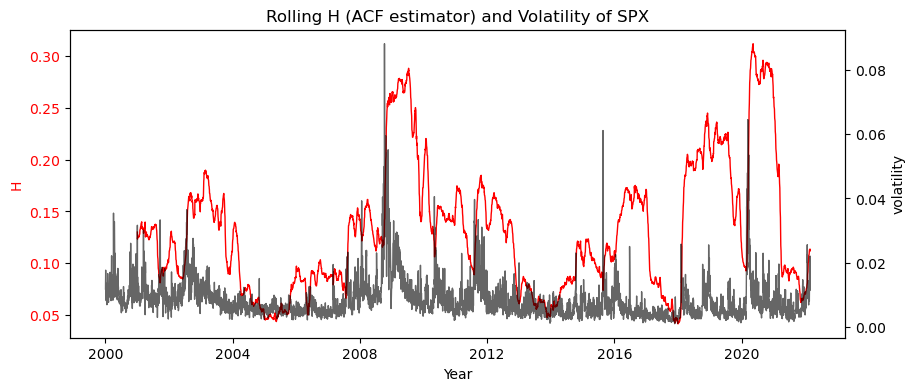

In [11]:
fig, ax1 = plt.subplots(figsize=(10, 4))

rv = np.sqrt(spx_rk)

# Left axis: Hurst exponent 
ax1.plot(
    rolling_H.index,
    rolling_H.values,
    color='red',
    linewidth=1,
)
ax1.set_ylabel('H', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Right axis: volatility
ax2 = ax1.twinx()
ax2.plot(
    # log_rv.index,
    # log_rv.values,
    rv.index,
    rv.values,
    color='k',
    alpha=0.6,
    linewidth=1,
)
# ax2.set_ylabel('log(volatility)', color='black')
ax2.set_ylabel('volatility', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# ---- Title & labels ----
ax1.set_xlabel('Year')
ax1.set_title('Rolling H (ACF estimator) and Volatility of SPX')

plt.savefig(f"{dir}/fig_5.png", dpi=200, bbox_inches='tight',
    pad_inches=0.1, facecolor='white', edgecolor='none')

plt.show()
